# Lab 2: Experiments with basic MLP networks  and visualising the results


## Read through all the cells that you are running to ensure you mostly understand what the code is doing ! 🙂
## (Not just run cells without looking at them!)
## (Modify things ... suggestions in the code ... look up documentation ... print out values ... to understand the code.)

Run the following cell to:

*   import relevant packages
*   setup appropriate matplotlib defaults

Make sure you read through this and understand what this is doing.


In [66]:
#@title
#from google.colab import files

# Common imports
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# Understanding simple networks

Let's try running some simple multi-layer perceptrons and see how they perform some basic regression and classification tasks. The goal here is to give you some insight into how a network represents the function or classifier, and what the impact of changing the parameters is.

Please do experiment with these models and try to work out how they work (a lot of it should look similar to what you did in the 60 minute PyTorch Blitz tutorial).


# Task 1 - Regression

We can start with a one dimensional regression task. A target system is $$ y = -\sin(10\pi (x+0.5)\sin(x^3))+\epsilon, $$where $\epsilon \sim \cal{N}(\mu, \sigma)$, and $\mu=0, \sigma=0.1$.



## Examine the following code.

Make sure you understand how this code is working (line by line).

**What are `xgrid`, `ytrue` being used for in this code?**

`xgrid` is used to create 100 x values from -0.5 to 0.5 that are shape(100,1)

`ytrue` is noise free y values based on xgrid

**What are `x`, `obserr` and `y` in the code?**

`x` is random x values between -0.5 and 0.5 in shape(N,1)

`obserr` is the noise generatored for each y value  in shape(N,1)

`y` is the y values with noise based on the `x` values in shape(N,1)

**What might you expect `xtest` and `ytest` are used for?**

`xtest` and `ytest` are likely used for training a linear regression model


Text(0, 0.5, '$y$')

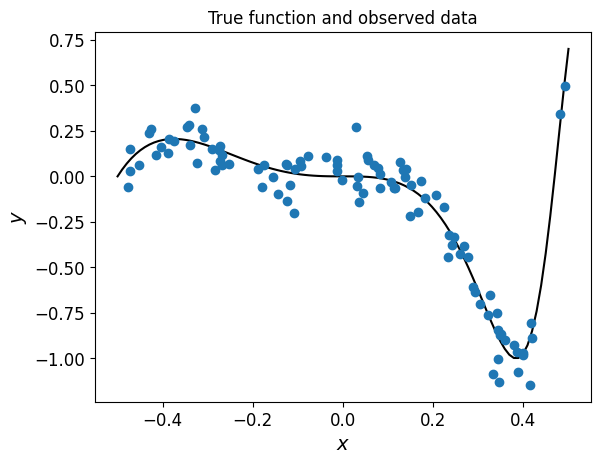

In [107]:
import math

def testfunc(x):
    # You might want to try this alternative function to experiment.
    #y = np.sin((4*math.pi*x**2))
    y = -np.sin((10*math.pi*(x+0.5)*np.sin((x)**3)))
    return y

xgrid = torch.t(torch.linspace(-0.5,0.5,100)).unsqueeze(1) 
ytrue = testfunc(xgrid) # clean data from underlying function (not available for learning)

# now create some training data
N = 100             # number of noisy training observations made
noiseSigma = 0.1    # standard deviation of noise
noiseMean = 0.0     # mean of noise

x = torch.rand_like(torch.ones(N,1))-0.5 # random x values between -0.5 and 0.5
obserr = torch.randn(N,1)*noiseSigma + noiseMean
y = testfunc(x)+obserr

xtest  = torch.rand_like(torch.ones(N,1))-0.5
obserr = torch.randn(N,1)*noiseSigma + noiseMean
ytest  = testfunc(xtest)+obserr

fig = plt.figure()
plt.plot(xgrid, ytrue,'-k')
plt.plot(x,y,'o')
plt.title('True function and observed data')
plt.xlabel('$x$')
plt.ylabel('$y$')

# Train a simple "fully connected" multi-layer perceptron (MLP) network to model this data.

Make sure you understand how this code is working - ask questions !

How many layers does this network have? How many neurons in the layers? Can you extend the number of layers? How many connections between the different layers? (See the output from the code ...)

Do you get an improvement of the loss over time? (Epochs of training) `yes but it plateaus`


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Nhidden = 80
lr = 0.01
epochs = 30000

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # An affine operation: y = Wx + b
        self.fc1 = nn.Linear(1, Nhidden)

        # See later in the notebook why you might want to do this !
        # self.fc1a = nn.Linear(Nhidden, Nhidden)
        
        self.fc2 = nn.Linear(Nhidden, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))

        # See later in the notebook why you might want to do this !
        # x = F.tanh(self.fc1a(x))
        
        x = self.fc2(x)
        return x

net = Net()
print(net)


criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

for epoch in range(epochs):
    running_loss = 0.0
    
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize
    outputs = net(x) # pytorch automatically calls net.forward(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0

print('Finished Training')




Net(
  (fc1): Linear(in_features=1, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=1, bias=True)
)


[2000,     1] loss: 0.052
[4000,     1] loss: 0.023
[6000,     1] loss: 0.014
[8000,     1] loss: 0.013
[10000,     1] loss: 0.012
[12000,     1] loss: 0.012
[14000,     1] loss: 0.012
[16000,     1] loss: 0.012
[18000,     1] loss: 0.012
[20000,     1] loss: 0.012
[22000,     1] loss: 0.012
[24000,     1] loss: 0.012
[26000,     1] loss: 0.012
[28000,     1] loss: 0.012
[30000,     1] loss: 0.012
Finished Training


# Use the model to do predictions!

Does it work as well as you would hope?

How about if you add in the extra layer into the network? (Need to go back and update the model.) How has it changed the "architecture" of the network in terms of layers, number of neurons in those layers and number of connections between the layers? How has this changed the loss over epochs ? How has it changed the fit given below ?

Text(0.5, 1.0, 'Regression comparison')

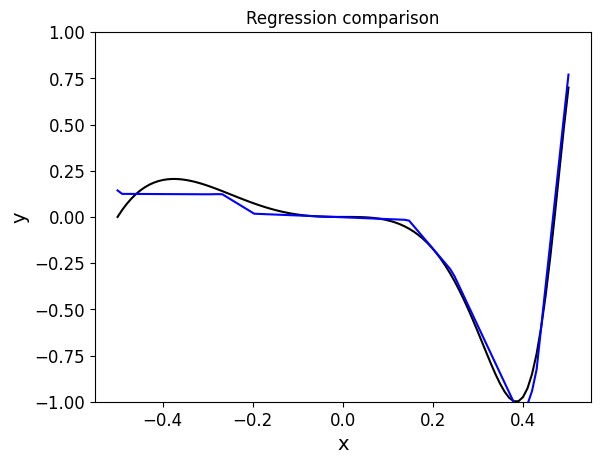

In [69]:
pred_y = net(x)
pred_ygrid = net(xgrid)

plt.figure()
plt.plot(xgrid, ytrue,'k-')
plt.plot(xgrid, pred_ygrid.detach().numpy(),'b-')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-1, 1])
plt.title('Regression comparison')

You can view the parameter values of the layers as a list of numpy arrays using the .weight command in pyTorch. Each layer can be accessed independently.

Do the number of weights and bias terms printed make sense here given the structure of this network ?




In [70]:
print('First hidden layer weights', torch.t(net.fc1.weight)) # first hidden layer weights (transposed for ease of inspection)
print('First hidden layer biases', net.fc1.bias) # first hidden layer biases
print('Second layer weights',net.fc2.weight) # second layer
print('Second layer bias', net.fc2.bias) # second layer

First hidden layer weights tensor([[-0.8801, -1.0522,  1.1118,  0.8591,  0.4025, -1.5528, -0.7574, -0.8006,
          0.8398,  0.5997,  3.8078,  0.2178, -1.6612, -0.7616, -1.5078,  0.7608,
          0.7955,  0.4696,  0.0151, -0.8338, -1.6681,  0.0671,  0.6243, -0.1374,
         -0.2010,  0.7852,  0.7764, -0.1744,  0.4650,  0.3672,  0.4814, -0.7629,
         -0.3396, -0.9844, -1.8776,  0.0317, -0.7449, -0.3283, -0.0281,  0.8143,
         -0.7876, -0.0691,  0.4347, -0.7367, -0.0133,  0.3195, -0.6971,  0.2810,
         -0.9717,  1.0844,  0.1120, -0.3275, -0.5833, -1.6702,  1.1076, -0.7037,
         -0.1248, -0.5873, -0.8329, -0.1461, -0.5377, -1.0830,  0.3602,  0.4777,
          0.5801,  0.2215, -0.4046, -0.6458, -0.0283,  0.4182,  0.9452,  0.1165,
         -0.2724,  0.9189,  0.4176, -0.6952, -0.3834, -0.4787,  0.3337,  0.1627]],
       grad_fn=<TBackward0>)
First hidden layer biases Parameter containing:
tensor([ 0.7082, -0.2822,  0.5451,  0.2584, -0.0583,  0.3763, -0.4026, -0.5248,
    

# Do further experimentation on this regression problem to improve it ...

Experiment (possibly changing one thing at a time for comparison) with:

1. The amount of training data (try 100, 200, 1000 points), and noise levels on the data (try 0.01 and 0.1 for noiseSigma).
2. The number of units (neurons) in the model (essentially the "width" of the network).
3. The choice of activation function.
4. Add an extra layer of hidden units to the network and compare performance between two layers of N units and one layer of 2N units (essentially the "depth" of the network).

Compare these by plotting a visualisation of the network output at `xgrid` inputs, and compare it with the `ytrue` results.



Creating some functions to speed up the plotting / reinforce understanding

In [71]:
def generate_data(N=100, noise_sigma=0.1, noise_mean=0.0):
    testfunc = lambda x: -np.sin((10*math.pi*(x+0.5)*np.sin((x)**3)))
    
    X_train = torch.rand_like(torch.ones(N,1))-0.5
    obserr = torch.randn(N,1)*noise_sigma + noise_mean
    y_train = testfunc(X_train)+obserr

    X_test  = torch.rand_like(torch.ones(N,1))-0.5
    obserr = torch.randn(N,1)*noise_sigma + noise_mean
    y_test  = testfunc(X_test)+obserr
    
    return X_train, X_test, y_train, y_test

In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

num_hidden_layers = 4
num_hidden_units = 80
activation_function = F.relu
   

class CustomNet(nn.Module):
    def __init__(self, num_hidden_layers, num_hidden_units, activation_function=F.relu):
        super(CustomNet, self).__init__()
        self.fc1 = nn.Linear(1, num_hidden_units)
        self.linears = nn.ModuleList([nn.Linear(num_hidden_units, num_hidden_units) for _ in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(num_hidden_units, 1)
        self.activation_function = activation_function

    def forward(self, x):
        x = self.activation_function(self.fc1(x))
        
        for hidden_layer in self.linears:
            x = self.activation_function(hidden_layer(x))

        x = self.fc2(x)
        return x

custom_nn = CustomNet(2, 80, F.relu)
print(custom_nn)
    
def test_train_nn(num_hidden_layers, num_hidden_units,X_train,y_train, activation_function=F.relu, lr=0.01, epochs=30000):
    custom_nn = CustomNet(num_hidden_layers, num_hidden_units, activation_function)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(custom_nn.parameters(), lr=lr, momentum=0.9)

    for epoch in range(epochs):
        running_loss = 0.0
        optimizer.zero_grad()
        outputs = custom_nn(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if epoch % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, 0 + 1, running_loss))
            running_loss = 0.0

    print('Finished Training')
    return custom_nn


CustomNet(
  (fc1): Linear(in_features=1, out_features=80, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=80, out_features=80, bias=True)
  )
  (fc2): Linear(in_features=80, out_features=1, bias=True)
)


Checking Test / Train Data

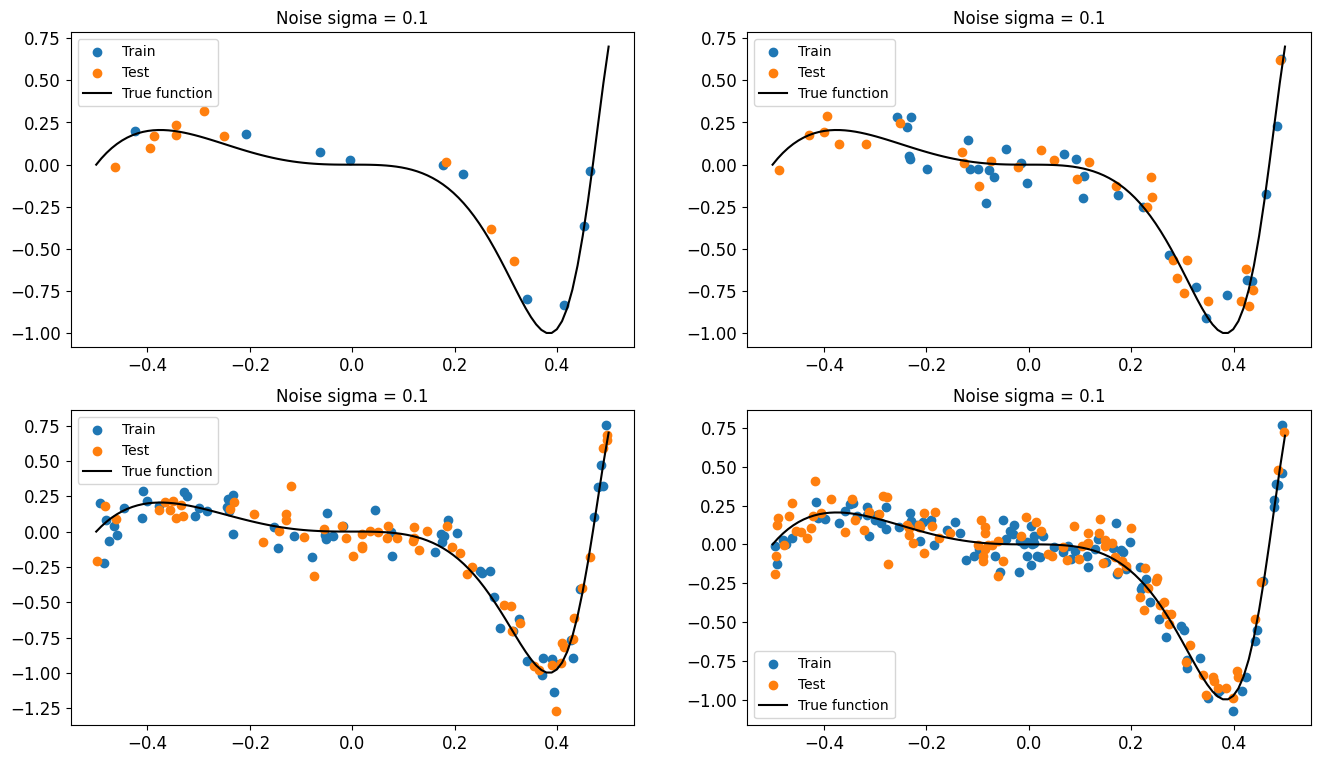

In [73]:
plt.figure(figsize=(16, 9))
plt.subplot(2,2,1)
for plot_num, var in enumerate([10, 30, 60, 100]):
    plt.subplot(2,2,plot_num+1)
    N=var
    noise_sigma=0.1
    noise_mean= 0
    X_train, X_test, y_train, y_test = generate_data(N=N, noise_sigma=noise_sigma, noise_mean=noise_mean)
    plt.scatter(X_train, y_train, label='Train')
    plt.scatter(X_test, y_test, label='Test')
    plt.plot(xgrid, ytrue, label='True function', color='black')
    plt.title(f'Noise sigma = {noise_sigma}')
    plt.legend()

Compare these by plotting a visualisation of the network output at `xgrid` inputs, and compare it with the `ytrue` results.

In [104]:
X_train, X_test, y_train, y_test = generate_data(N=1000, noise_sigma=0.1, noise_mean=0.0)
custom_nn = test_train_nn(num_hidden_layers=4, num_hidden_units=50,X_train=X_train,y_train=y_train, activation_function=F.relu, lr=0.01, epochs=30000)

[2000,     1] loss: 0.004
[4000,     1] loss: 0.000
[6000,     1] loss: 0.000
[8000,     1] loss: 0.000
[10000,     1] loss: 0.000
[12000,     1] loss: 0.000
[14000,     1] loss: 0.000
[16000,     1] loss: 0.000
[18000,     1] loss: 0.000
[20000,     1] loss: 0.000
[22000,     1] loss: 0.000
[24000,     1] loss: 0.000
[26000,     1] loss: 0.000
[28000,     1] loss: 0.000
[30000,     1] loss: 0.000
Finished Training


[2000,     1] loss: 0.031
[4000,     1] loss: 0.009
[6000,     1] loss: 0.004
[8000,     1] loss: 0.002
[10000,     1] loss: 0.002
[12000,     1] loss: 0.001
[14000,     1] loss: 0.001
[16000,     1] loss: 0.001
[18000,     1] loss: 0.001
[20000,     1] loss: 0.001
[22000,     1] loss: 0.001
[24000,     1] loss: 0.001
[26000,     1] loss: 0.001
[28000,     1] loss: 0.001
[30000,     1] loss: 0.001
Finished Training
[2000,     1] loss: 0.035
[4000,     1] loss: 0.010
[6000,     1] loss: 0.003
[8000,     1] loss: 0.002
[10000,     1] loss: 0.001
[12000,     1] loss: 0.001
[14000,     1] loss: 0.001
[16000,     1] loss: 0.001
[18000,     1] loss: 0.001
[20000,     1] loss: 0.001
[22000,     1] loss: 0.001
[24000,     1] loss: 0.001
[26000,     1] loss: 0.000
[28000,     1] loss: 0.000
[30000,     1] loss: 0.000
Finished Training
[2000,     1] loss: 0.029
[4000,     1] loss: 0.027
[6000,     1] loss: 0.023
[8000,     1] loss: 0.020
[10000,     1] loss: 0.017
[12000,     1] loss: 0.015
[140

Text(0.5, 1.0, 'Model with 1 hidden layer - 50 units - Relu activation - Noise sigma = 0.1 - 1000 points')

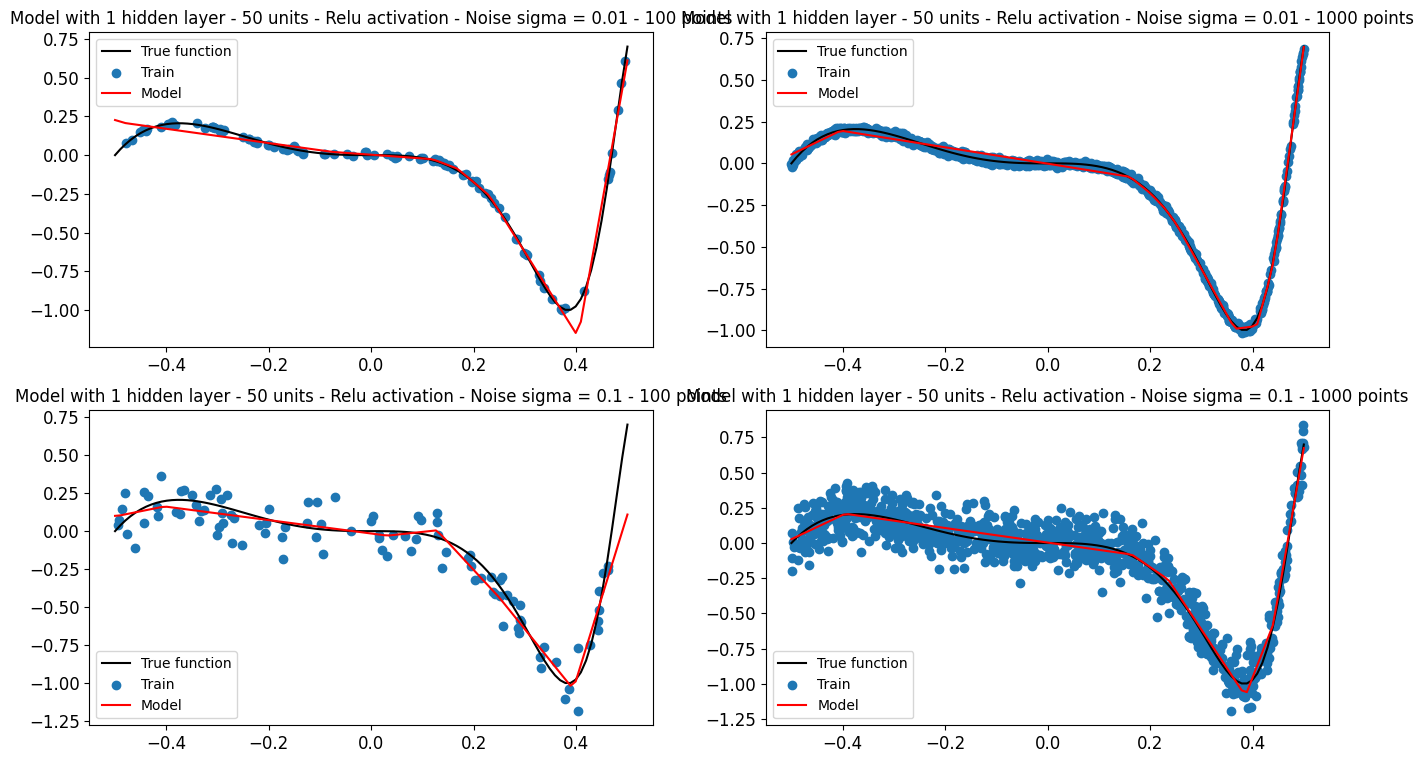

In [112]:
def plot_model():
    y_model = custom_nn(xgrid).detach().numpy().flatten()
    xgrid_plot = xgrid.detach().numpy().flatten()
    plt.plot(xgrid, ytrue, label='True function', color='black')
    plt.scatter(X_train, y_train, label='Train')
    plt.plot(xgrid, y_model, label='Model', color='red')
    plt.legend()


plt.figure(figsize=(16, 9))

"""
    Experiment (possibly changing one thing at a time for comparison) with:

1. The amount of training data (try 100, 200, 1000 points), and noise levels on the data (try 0.01 and 0.1 for noiseSigma).
2. The number of units (neurons) in the model (essentially the "width" of the network).
3. The choice of activation function.
4. Add an extra layer of hidden units to the network and compare performance between two layers of N units and one layer of 2N units (essentially the "depth" of the network).

Compare these by plotting a visualisation of the network output at `xgrid` inputs, and compare it with the `ytrue` results.
"""

plt.subplot(2,2,1)

X_train, X_test, y_train, y_test = generate_data(N=100, noise_sigma=0.01, noise_mean=0.0)
custom_nn = test_train_nn(num_hidden_layers=1, num_hidden_units=50,X_train=X_train,y_train=y_train, activation_function=F.relu, lr=0.01, epochs=30000)
plot_model()
plt.title('Model with 1 hidden layer - 50 units - Relu activation - Noise sigma = 0.01 - 100 points')

plt.subplot(2,2,2)

X_train, X_test, y_train, y_test = generate_data(N=1000, noise_sigma=0.01, noise_mean=0.0)
custom_nn = test_train_nn(num_hidden_layers=1, num_hidden_units=50,X_train=X_train,y_train=y_train, activation_function=F.relu, lr=0.01, epochs=30000)
plot_model()
plt.title('Model with 1 hidden layer - 50 units - Relu activation - Noise sigma = 0.01 - 1000 points')

plt.subplot(2,2,3)

X_train, X_test, y_train, y_test = generate_data(N=100, noise_sigma=0.1, noise_mean=0.0)
custom_nn = test_train_nn(num_hidden_layers=1, num_hidden_units=50,X_train=X_train,y_train=y_train, activation_function=F.relu, lr=0.01, epochs=30000)
plot_model()
plt.title('Model with 1 hidden layer - 50 units - Relu activation - Noise sigma = 0.1 - 100 points')

plt.subplot(2,2,4)

X_train, X_test, y_train, y_test = generate_data(N=1000, noise_sigma=0.1, noise_mean=0.0)
custom_nn = test_train_nn(num_hidden_layers=1, num_hidden_units=50,X_train=X_train,y_train=y_train, activation_function=F.relu, lr=0.01, epochs=30000)
plot_model()
plt.title('Model with 1 hidden layer - 50 units - Relu activation - Noise sigma = 0.1 - 1000 points')


[2000,     1] loss: 0.012
[4000,     1] loss: 0.011
[6000,     1] loss: 0.011
[8000,     1] loss: 0.010
[10000,     1] loss: 0.010
[12000,     1] loss: 0.010
[14000,     1] loss: 0.010
[16000,     1] loss: 0.010
[18000,     1] loss: 0.010
[20000,     1] loss: 0.010
[22000,     1] loss: 0.010
[24000,     1] loss: 0.010
[26000,     1] loss: 0.010
[28000,     1] loss: 0.010
[30000,     1] loss: 0.010
Finished Training
[2000,     1] loss: 0.010
[4000,     1] loss: 0.010
[6000,     1] loss: 0.010
[8000,     1] loss: 0.010
[10000,     1] loss: 0.010
[12000,     1] loss: 0.009
[14000,     1] loss: 0.009
[16000,     1] loss: 0.009
[18000,     1] loss: 0.009
[20000,     1] loss: 0.009
[22000,     1] loss: 0.009
[24000,     1] loss: 0.009
[26000,     1] loss: 0.009
[28000,     1] loss: 0.009
[30000,     1] loss: 0.009
Finished Training
[2000,     1] loss: 0.014
[4000,     1] loss: 0.009
[6000,     1] loss: 0.009
[8000,     1] loss: 0.009
[10000,     1] loss: 0.009
[12000,     1] loss: 0.009
[140

Text(0.5, 1.0, 'Model with 1 hidden layer - 100 units - relu activation - Noise sigma = 0.1 - 250 points')

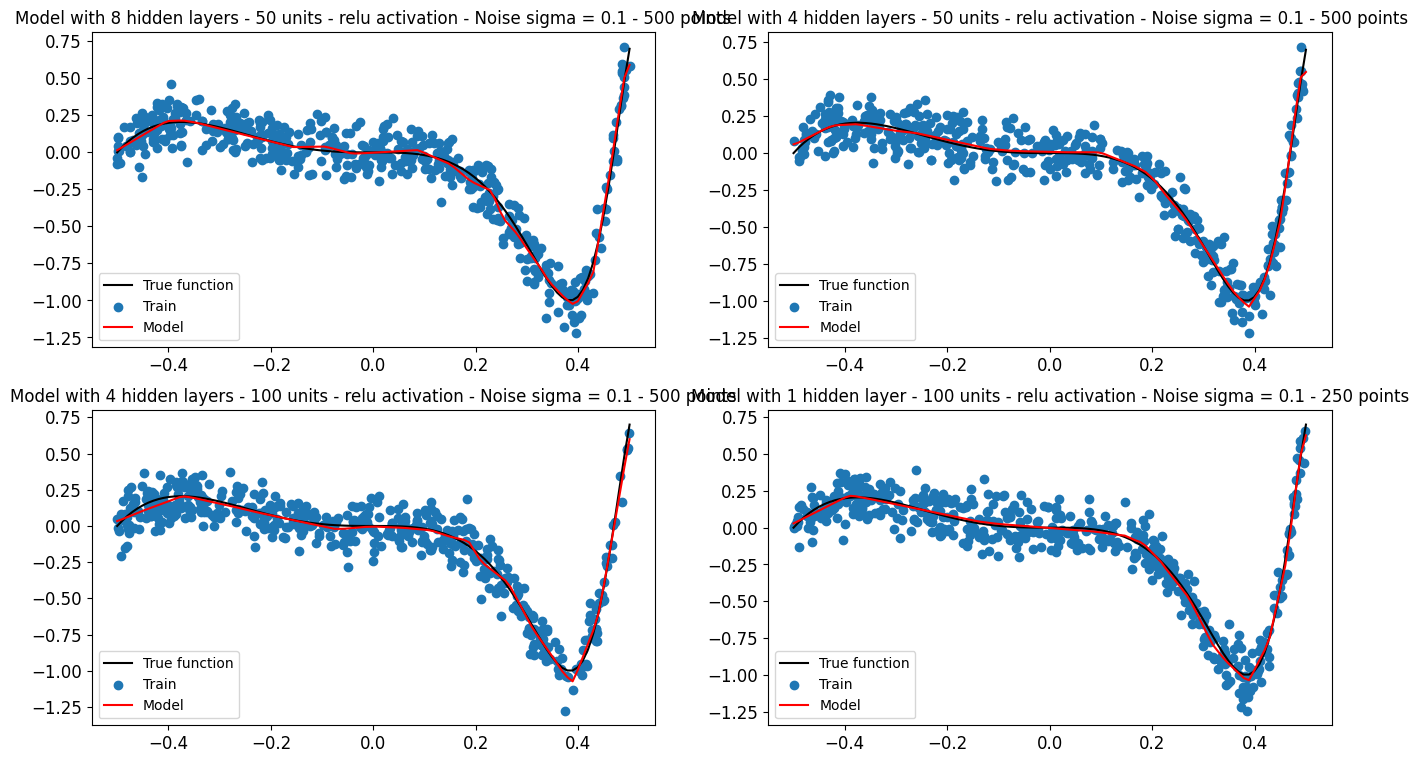

In [114]:
plt.figure(figsize=(16, 9))

"""
    Experiment (possibly changing one thing at a time for comparison) with:

1. The amount of training data (try 100, 200, 1000 points), and noise levels on the data (try 0.01 and 0.1 for noiseSigma).
2. The number of units (neurons) in the model (essentially the "width" of the network).
3. The choice of activation function.
4. Add an extra layer of hidden units to the network and compare performance between two layers of N units and one layer of 2N units (essentially the "depth" of the network).

Compare these by plotting a visualisation of the network output at `xgrid` inputs, and compare it with the `ytrue` results.
"""

plt.subplot(2,2,1)

X_train, X_test, y_train, y_test = generate_data(N=500, noise_sigma=0.1, noise_mean=0.0)
custom_nn = test_train_nn(num_hidden_layers=8, num_hidden_units=50,X_train=X_train,y_train=y_train, activation_function=F.relu, lr=0.01, epochs=30000)
plot_model()
plt.title('Model with 8 hidden layers - 50 units - relu activation - Noise sigma = 0.1 - 500 points')

plt.subplot(2,2,2)

X_train, X_test, y_train, y_test = generate_data(N=500, noise_sigma=0.1, noise_mean=0.0)
custom_nn = test_train_nn(num_hidden_layers=4, num_hidden_units=50,X_train=X_train,y_train=y_train, activation_function=F.relu, lr=0.01, epochs=30000)
plot_model()
plt.title('Model with 4 hidden layers - 50 units - relu activation - Noise sigma = 0.1 - 500 points')

plt.subplot(2,2,3)

X_train, X_test, y_train, y_test = generate_data(N=500, noise_sigma=0.1, noise_mean=0.0)
custom_nn = test_train_nn(num_hidden_layers=4, num_hidden_units=100,X_train=X_train,y_train=y_train, activation_function=F.relu, lr=0.01, epochs=30000)
plot_model()
plt.title('Model with 4 hidden layers - 100 units - relu activation - Noise sigma = 0.1 - 500 points')

plt.subplot(2,2,4)

X_train, X_test, y_train, y_test = generate_data(N=500, noise_sigma=0.1, noise_mean=0.0)
custom_nn = test_train_nn(num_hidden_layers=2, num_hidden_units=100,X_train=X_train,y_train=y_train, activation_function=F.relu, lr=0.01, epochs=30000)
plot_model()
plt.title('Model with 2 hidden layers - 100 units - relu activation - Noise sigma = 0.1 - 500 points')



---



# Task 2 - Classification

Now we will try out some experiments with simple two-dimensional classification tasks. Again read through the code to make sure you feel you understand how it is working. For instance, how does meshgrid() work? Look it up in the PyTorch documentation if you are not sure what it is doing. See if you can work out the shape (or size) of the tensors involved (can always print out value.shape to checkthis !) For instance, what shape does `x` have in this code ?


**Dataset 1**


420


Text(0, 0.5, '$x_2$')

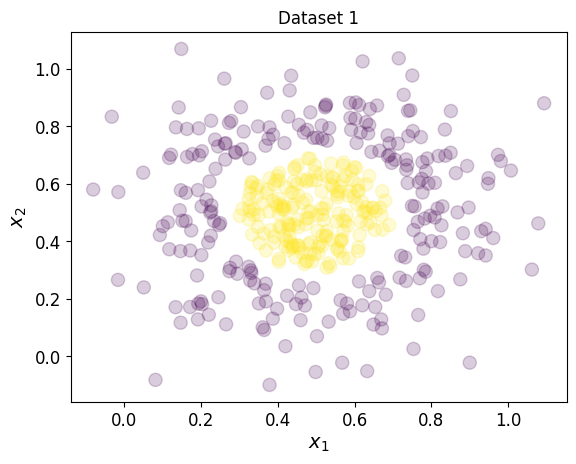

In [173]:
N = 500

xgrid = torch.arange(0,1.0,0.01)

X,Y = torch.meshgrid(xgrid, xgrid)


testgrid = torch.zeros((np.shape(xgrid)[0]**2,2))
testgrid[:,0] = X.flatten()
testgrid[:,1] = Y.flatten()

# What distribution is produced by torch.randn ?
# Try experimenting with different types of input distribution
# x = np.random.uniform(low = 0.0, high = 1.0, size= (N,2))

x = 0.2*torch.randn(N,2)+torch.tensor([0.5, 0.5])
y = ((torch.linalg.vector_norm(x-0.5, dim=1) < 0.2)*1.0).type(torch.float)  # make the class be a circle in the centre of the scene.


# # cut out a border around the classes to make the task a bit more realistic
ind_incl = (torch.linalg.vector_norm(x-0.5, dim=1) > 0.25) | (torch.linalg.vector_norm(x-0.5, dim=1) < 0.20)
x = x[ind_incl,:]
y = y[ind_incl]
N = y.shape[0]
y = y.reshape(N,1)
print(N)


Ntest = 1000
xtest = 0.2*torch.randn(Ntest,2)+torch.tensor([0.5, 0.5])
ytest = ((torch.linalg.vector_norm(xtest-0.5, dim=1) < 0.2)*1.0).type(torch.float)

# # cut out a border around the classes to make the task a bit more realistic
ind_incl = (torch.norm(xtest-0.5, dim=1) > 0.25) | (torch.norm(xtest-0.5, dim=1) < 0.20)
xtest = xtest[ind_incl,:]
ytest = ytest[ind_incl]
Ntest = ytest.shape[0]
ytest = ytest.reshape(Ntest,1)

plt.figure()
plt.scatter(x[:,0].numpy(),x[:,1].numpy(), alpha=0.2, s=90, cmap='viridis', c=y.view(-1))
plt.title('Dataset 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

---

# Define a suitable MLP or "fully-connected" model

This type of simple network can alternatively be created using the nn.Sequential container. See this [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) class page in the PyTorch documentation for an example of this.


What is the size of the input to this model? What is the size of output? Why do we have a sigmoid activation function on the output? `This is binary classification so we want a value between 0 and 1`


In [184]:
Nhidden = 50
lamb=0.00001    # L2 weight decay term
lr = 0.01
epochs = 20000


class Net2d(nn.Module):
    def __init__(self):
        super(Net2d, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, Nhidden)
        self.fc2 = nn.Linear(Nhidden, Nhidden)
        self.fc3 = nn.Linear(Nhidden, Nhidden)
        self.fc4 = nn.Linear(Nhidden, Nhidden)
        self.fc5 = nn.Linear(Nhidden, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

net2d = Net2d()
print(net2d)



Net2d(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=1, bias=True)
)


# Training the network

What type of loss are we using here? Why are we not using MSELoss ? `This is binary classification so Binary Cross Entropy is used`

In [185]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net2d.parameters(), lr=lr, momentum=0.9, weight_decay=lamb) # Note that this is adding L2 regularisation with factor lamb to every parameter

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net2d(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0


[2000,     1] loss: 0.047
[4000,     1] loss: 0.001
[6000,     1] loss: 0.000
[8000,     1] loss: 0.000
[10000,     1] loss: 0.000
[12000,     1] loss: 0.000
[14000,     1] loss: 0.000
[16000,     1] loss: 0.000
[18000,     1] loss: 0.000
[20000,     1] loss: 0.000


# Using the network to do prediction

Final training set loss  3.775036384467967e-05
Test loss  0.00018518170691095293
Percentage correct  100.0


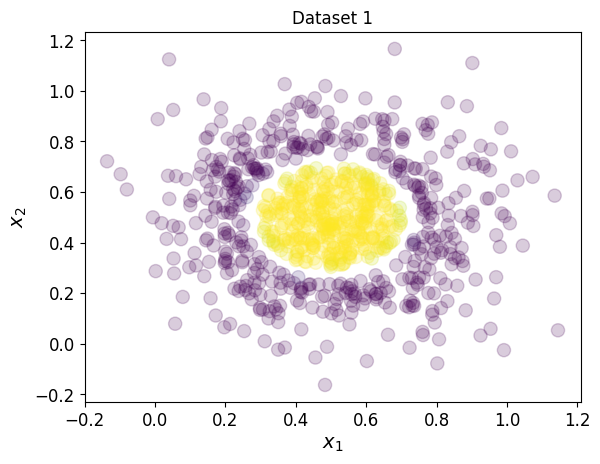

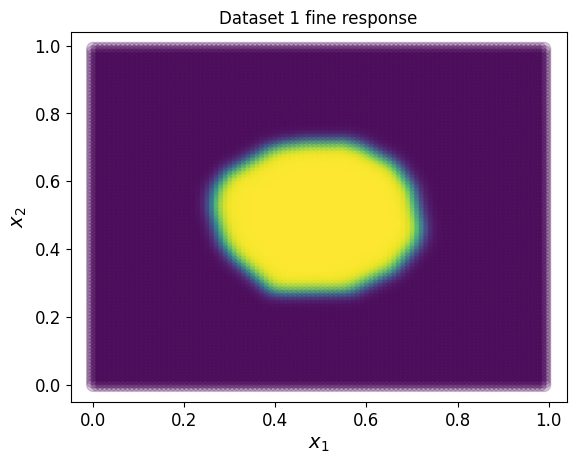

In [186]:
pred_test = net2d(xtest)

plt.figure()
plt.scatter(xtest[:,0],xtest[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_test[:,0].detach().numpy())
plt.title('Dataset 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

pred_testgrid = net2d(testgrid)
plt.figure()
plt.scatter(testgrid[:,0],testgrid[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_testgrid[:,0].detach().numpy())
plt.title('Dataset 1 fine response')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

print('Final training set loss ', criterion(outputs, y).item())
test_loss = criterion(pred_test, ytest)
print('Test loss ', test_loss.item())
classification = torch.round(pred_test)
percentage = 100*sum(ytest.type(torch.int) == classification.type(torch.int))/Ntest
print('Percentage correct ', percentage.item())

# Experiment with the following ...

Try repeating these experiments with the following variations:
- Try with 200, 500, 2000 training points. How does that change the response of the function?
- Try changing the number of hidden units. What changes?
    - Do you see as many 'edges' on the decision boundary when using ReLUs as units? Why do you think this is?
    - Try with 1,2,3 hidden layers.
- Try with Sigmoids in the hidden layer rather than ReLUs.
    - How does that change the shape of the decision boundary? Why do you think this is?
    - How does it change the speed of error reduction?

- Try changing the loss function from Binary Cross-Entropy (`BCEloss`) to `MSEloss`. How does that affect performance? How does it affect perfomance in `mse`?
- During the above you may find that some configurations take a lot longer to reduce the error than others.


The correct choice of loss function is linked to the output type, as shown in the table below:

![output/cost function table](https://docs.google.com/uc?export=download&id=1Z2C-NJh35shzvtMlvEtDpyQgGM10bvew)







---



# Task 3 - Classification


Let's do a classification based on the boundary that we used for regression !

---

**Dataset 2**

Text(0, 0.5, '$x_2$')

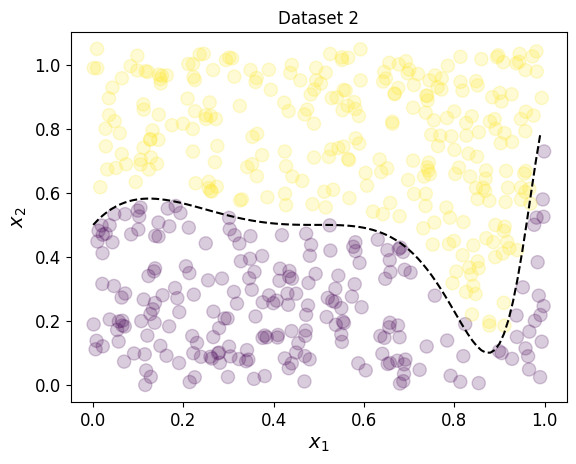

In [187]:
N = 500   # Try 100, 500, 1000

xgrid1 = torch.arange(0,1.0,0.01)

#try experimenting with different types of input distribution
data_dist = 1 # 1 - uniform 0.5-0.5, 2 - normally distributed

if data_dist == 1:
   x = torch.rand(N,2)
else:
   x = 0.15*torch.randn(N,2)+torch.tensor([0.5, 0.5])
ind_pos = (0.5+0.4*testfunc(x[:,0]-0.5)<x[:,1])
y = (ind_pos*1.0).type(torch.float)  # lets create a classification line based on old regression function
N = y.shape[0]
y = y.reshape(N,1)
x[ind_pos,1] = x[ind_pos,1]+0.05 # create a gap between classes.


if data_dist == 1:
  xtest = torch.rand(N,2)
else:
  xtest = 0.15*torch.randn(N,2)+torch.tensor([0.5, 0.5])
ind_post = (0.5+0.4*testfunc(xtest[:,0]-0.5)<xtest[:,1])
ytest = (ind_post*1.0).type(torch.float)  # let's create a classification line based on old regression function
Ntest = ytest.shape[0]
ytest = ytest.reshape(Ntest,1)
xtest[ind_post,1] = xtest[ind_post,1]+0.05 # create a gap between classes.


plt.figure()
plt.scatter(x[:,0],x[:,1], alpha=0.2, s=90, cmap='viridis', c=y.view(-1))
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for this problem
plt.title('Dataset 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')



# Define the model

This time we will use the Sequential container that was mentioned above to define this model.

In [188]:
Nhidden = 10 # experiment with this
lamb=0.00
lr = 0.01
epochs = 50000


net2d = nn.Sequential(nn.Linear(2,Nhidden),
                      nn.ReLU(),
                      nn.Linear(Nhidden, Nhidden),
                      nn.ReLU(),
                      nn.Linear(Nhidden, 1),
                      nn.Sigmoid())
# reuse net2d variable.


# Train the model

Does the loss change during training? What is this telling you?

In [189]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net2d.parameters(), lr=lr, momentum=0.9, weight_decay=lamb) # Note that this is adding L2 regularisation with factor lamb to every parameter

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net2d(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0

[2000,     1] loss: 0.141
[4000,     1] loss: 0.120
[6000,     1] loss: 0.076
[8000,     1] loss: 0.043
[10000,     1] loss: 0.027
[12000,     1] loss: 0.019
[14000,     1] loss: 0.014
[16000,     1] loss: 0.011
[18000,     1] loss: 0.009
[20000,     1] loss: 0.008
[22000,     1] loss: 0.007
[24000,     1] loss: 0.006
[26000,     1] loss: 0.006
[28000,     1] loss: 0.005
[30000,     1] loss: 0.005
[32000,     1] loss: 0.004
[34000,     1] loss: 0.004
[36000,     1] loss: 0.004
[38000,     1] loss: 0.004
[40000,     1] loss: 0.003
[42000,     1] loss: 0.003
[44000,     1] loss: 0.003
[46000,     1] loss: 0.003
[48000,     1] loss: 0.003
[50000,     1] loss: 0.003


# Do prediction on the test set using the model

Final training set loss  0.002528334502130747
Test loss  0.004037088248878717
Percentage correct  100.0


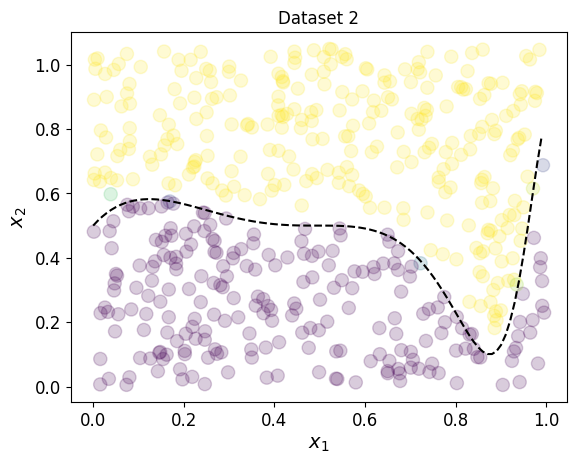

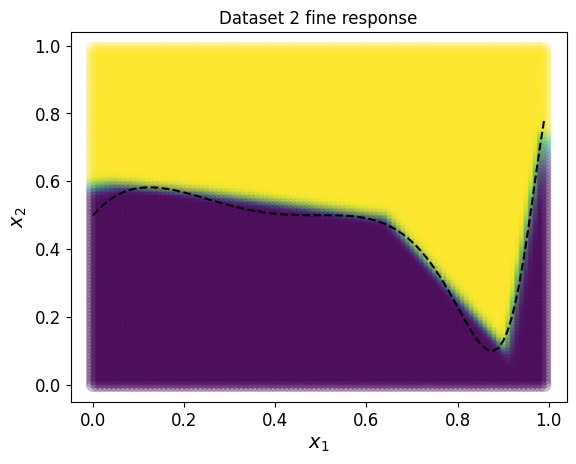

In [190]:
pred_test = net2d(xtest)
plt.figure()
plt.scatter(xtest[:,0],xtest[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_test[:,0].detach().numpy())
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for dataset2 problem
plt.title('Dataset 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

pred_testgrid = net2d(testgrid)
plt.figure()
plt.scatter(testgrid[:,0],testgrid[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_testgrid[:,0].detach().numpy())
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for this problem
plt.title('Dataset 2 fine response')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

print('Final training set loss ', criterion(outputs, y).item())
test_loss = criterion(pred_test, ytest)
print('Test loss ', test_loss.item())
classification = torch.round(pred_test)
percentage = 100.0*torch.sum(ytest.type(torch.int) == classification.type(torch.int))/Ntest
print('Percentage correct ', percentage.item())

# Try experimenting with the following aspects of this network:

Try changing the distribution of the training data (e.g. make it normally distributed) but keeping the same classification boundary. How does that change the resulting classification boundary?

Try with N= 100, 500, 1000 training examples with linearly distribute and normally distributed data. What is this telling you?

Try different sizes of network to see what differences result.

What happens with small training sets and large networks?

1. Changing the Distribution of Training Data:

Try changing the distribution of the training data while keeping the same classification boundary. For instance, switch from uniform to normally distributed data.

    Observation: The model should ideally learn the classification boundary regardless of the input data distribution. However, the choice of distribution might affect the convergence speed and generalization performance. Normally distributed data might introduce noise or outliers that could impact training.

2. Varying the Size of the Training Set:

Experiment with different sizes of the training set (N=100, 500, 1000) for both linearly distributed and normally distributed data.

    Observation: Increasing the size of the training set generally provides more information for the model to learn from, potentially improving its performance. Smaller training sets might lead to overfitting, especially with larger networks.

3. Trying Different Network Sizes:

Explore the effect of different network sizes on the resulting classification boundary.

    Observation: Larger networks can learn more complex decision boundaries but may also be prone to overfitting, especially with limited training data. Smaller networks might be insufficient to capture intricate patterns in the data.

4. Small Training Sets and Large Networks:

Investigate the performance of the model when using a small training set with a large network.

    Observation: With a small training set, a large network might memorize the training examples, leading to poor generalization on unseen data. Overfitting becomes a significant concern. Regularization techniques (dropout, weight decay) could be crucial in this scenario.